# Variation due to `word2vec`'s random initialisation

 - fairly small at the word analogy task

In [3]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from gui.output_utils import *
from gui.user_code import pretty_names

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [4]:
def get_exp_ids_for_reruns_of_word2vec(corpus='amazon_grouped-tagged', rep=0):
    query_dict = {
        'expansions__use_similarity': 0, 
          'expansions__neighbour_strategy':'linear',
          'expansions__vectors__dimensionality': 100, 
          'document_features_ev': 'AN+NN', 
          'document_features_tr': 'J+N+AN+NN', 
          'expansions__allow_overlap': False,
          'expansions__entries_of': None,
          'expansions__vectors__algorithm': 'word2vec',
          'expansions__vectors__composer__in': ['Add', 'Mult', 'Left', 'Right'], # todo Verb???
          'expansions__vectors__unlabelled': 'wiki',
          'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
          'expansions__noise': 0,
          'expansions__use_similarity': 0, 
          'expansions__k':3,
          'expansions__vectors__unlabelled_percentage': 50,
          'expansions__vectors__rep': rep,
          'labelled':corpus}
    return Experiment.objects.filter(**query_dict).values_list('id', flat=True)

[[62, 63, 64, 65], [66, 67, 68, 69], [70, 71, 72, 73], [58, 59, 60, 61]]
['0', '1', '2', 'avg']


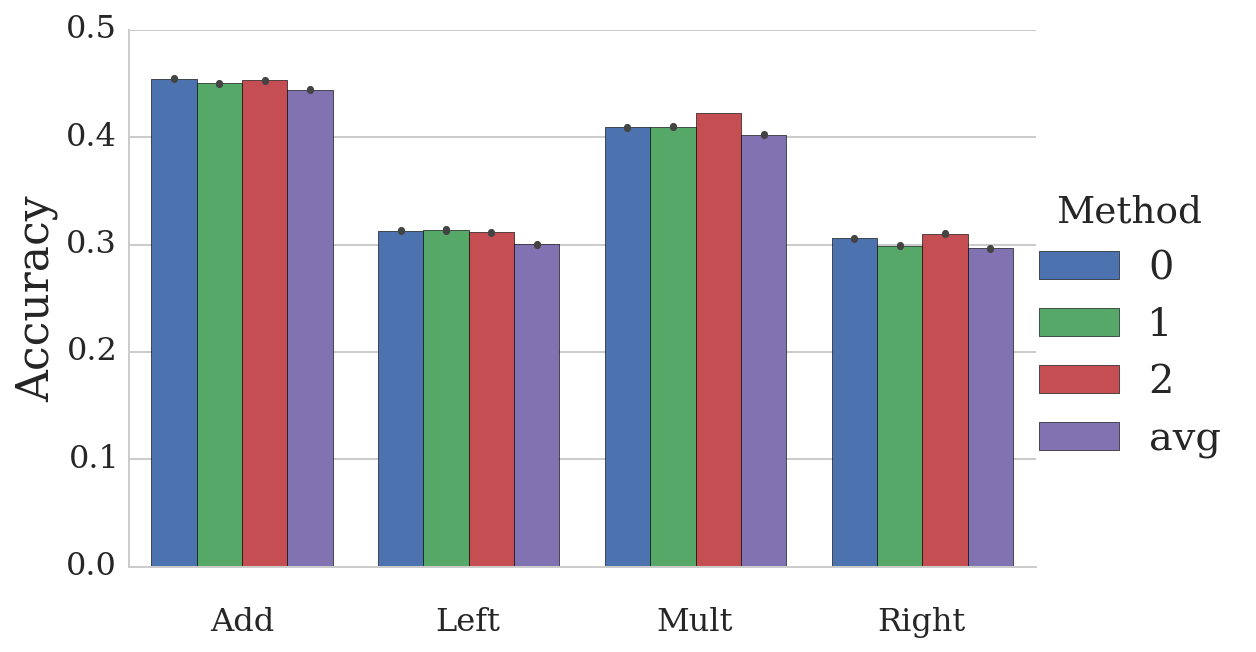

In [5]:
ids = [get_exp_ids_for_reruns_of_word2vec(rep=r) for r in [0, 1, 2, -1]]
print(ids)    
hue_order = pretty_names([x[0] for x in ids], 
                    name_format=['expansions__vectors__rep'])
hue_order[-1] = 'avg'
print(hue_order)
composers = pretty_names(ids[0], 
                    name_format=['expansions__vectors__composer'])

diff_plot_bar(ids, hue_order, composers, hue_order=hue_order)
plt.savefig('plot-w2v_random_init_var.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)